# Pytorchを使ってCIFAR10データセットのAIモデルを作る

### モジュールのインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# GPUの検証を行う
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### データセットのダウンロード

In [3]:
dataset = torchvision.datasets.CIFAR10(root="./dataset/", download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))

Files already downloaded and verified


In [4]:
print(dataset)
print(type(dataset))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
<class 'torchvision.datasets.cifar.CIFAR10'>


In [5]:
dataset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


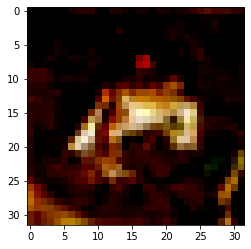

In [6]:
# 最初の画像を表示してみる
image, label = dataset[0]

image = image.permute(1, 2, 0)

plt.imshow(image)
print(label) # flog

### 各ラベルの名前を設定する

インデックストラベルの関係は以下の通り

- 0: airplane </br>
- 1: car</br>
- 2: bird</br>
- 3: cat</br>
- 4: deer</br>
- 5: dog</br>
- 6: frog</br>
- 7: horse</br>
- 8: ship</br>
- 9: truck</br>



In [7]:
label_name = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### DataLoader()をそれぞれ作成する

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('./dataset/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])), batch_size=128, shuffle=False)

Files already downloaded and verified


### ネットワークを作成する

層が大きくなると計算するのに時間がかかりそうだったので、とりあえず以下のサイトのモデルをそのまま実装してみる

- [my_CNN](https://kdl-di.hatenablog.com/entry/2021/12/24/090000)
- [my_CNN2](https://rightcode.co.jp/blog/information-technology/pytorch-cifar-10-cnn-learning-gpu-dropout)

In [9]:
# class my_CNN(nn.Module):

#     def __init__(self):
#         super().__init__()

#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)

#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x

class my_CNN2(nn.Module):
    def __init__(self):
        super().__init__()

        # self.conv1 = torch.nn.Conv2d(3, 6, 5)
        # self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # self.conv3 = torch.nn.Conv2d(16, 32, 3)
        # self.conv4 = torch.nn.Conv2d(32, 16, 3)
 
        # self.pool = torch.nn.MaxPool2d(2, 2)
 
        # self.dropout1 = torch.nn.Dropout2d(p=0.3)
        # self.dropout2 = torch.nn.Dropout(p=0.5)
 
        # self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)  
        
        # self.fc2 = torch.nn.Linear(120, 84)
        # self.fc3 = torch.nn.Linear(84, 10)
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.dropout1 = torch.nn.Dropout2d(p=0.3)
        self.dropout2 = torch.nn.Dropout(p=0.5)

        self.fc1 = torch.nn.Linear(256*4*4, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 10)
    def forward(self, x):

        # x = F.relu(self.conv1(x))
        # x = self.pool(x)
        # x = F.relu(self.conv2(x))
        # x = self.pool(x)
        # x = F.relu(self.conv3(x))
        # x = F.relu(self.conv4(x))
        # x = self.pool(x)
        # x = self.dropout1(x)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

### 損失関数と最適化関数を定義する

`optimizer`はたくさんの種類があったが、今回は`Adam`, `SGD`の2種類を使って比較してみる

In [10]:
model = my_CNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

### モデルの学習を開始する

トレーニング、テストをすべてここで行っているため若干効率は悪そう。<br>
あとローカルでやっているからかもしれない

今回は50回の学習を行い40回目の学習で学習率を変換して実装してみる

In [11]:
loss_history = []
train_acc = []
valid_acc = []
test_acc = []
epoch = 50

for e in range(epoch):
    loss_epoch = 0

    # 40回目の学習の時に学習率を変更する
    if e == 40:
        optimizer.param_groups[0]['lr'] = 1e-4
        print("chenged learning rate to 1e-4")

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        loss_epoch += loss.item()

        optimizer.step()
        
    print(f"training log: {e + 1} epoch ({(i+1) * 128}) Loss: {loss.item()}")

    loss_history.append(loss_epoch)
    model.eval()

# train_dataset
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        print(correct)
    
        acc = float(correct / 50000)
        train_acc.append(acc)

# test dataset
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        
        acc = float(correct / 10000)
        test_acc.append(acc)

    


training log: 1 epoch (50048) Loss: 2.3040876388549805


100%|██████████| 391/391 [00:12<00:00, 30.13it/s]


5000


100%|██████████| 79/79 [00:02<00:00, 28.82it/s]


training log: 2 epoch (50048) Loss: 2.303508758544922


100%|██████████| 391/391 [00:12<00:00, 30.21it/s]


5000


100%|██████████| 79/79 [00:02<00:00, 28.23it/s]


training log: 3 epoch (50048) Loss: 2.302269697189331


100%|██████████| 391/391 [00:13<00:00, 29.97it/s]


5012


100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


training log: 4 epoch (50048) Loss: 2.3031115531921387


100%|██████████| 391/391 [00:12<00:00, 30.23it/s]


6006


100%|██████████| 79/79 [00:02<00:00, 28.53it/s]


training log: 5 epoch (50048) Loss: 2.30289626121521


100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


8131


100%|██████████| 79/79 [00:02<00:00, 28.60it/s]


training log: 6 epoch (50048) Loss: 2.3026888370513916


100%|██████████| 391/391 [00:13<00:00, 29.98it/s]


5000


100%|██████████| 79/79 [00:02<00:00, 28.59it/s]


training log: 7 epoch (50048) Loss: 2.3023722171783447


100%|██████████| 391/391 [00:12<00:00, 30.18it/s]


7075


100%|██████████| 79/79 [00:02<00:00, 28.84it/s]


training log: 8 epoch (50048) Loss: 2.3022704124450684


100%|██████████| 391/391 [00:12<00:00, 30.11it/s]


6766


100%|██████████| 79/79 [00:02<00:00, 28.56it/s]


training log: 9 epoch (50048) Loss: 2.3022313117980957


100%|██████████| 391/391 [00:13<00:00, 29.95it/s]


7182


100%|██████████| 79/79 [00:02<00:00, 27.95it/s]


training log: 10 epoch (50048) Loss: 2.302124500274658


100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


7998


100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


training log: 11 epoch (50048) Loss: 2.301954746246338


100%|██████████| 391/391 [00:12<00:00, 30.19it/s]


8818


100%|██████████| 79/79 [00:02<00:00, 28.73it/s]


training log: 12 epoch (50048) Loss: 2.3019824028015137


100%|██████████| 391/391 [00:13<00:00, 30.06it/s]


9683


100%|██████████| 79/79 [00:02<00:00, 28.86it/s]


training log: 13 epoch (50048) Loss: 2.3017382621765137


100%|██████████| 391/391 [00:13<00:00, 29.99it/s]


10343


100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


training log: 14 epoch (50048) Loss: 2.3013150691986084


100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


10070


100%|██████████| 79/79 [00:02<00:00, 28.31it/s]


training log: 15 epoch (50048) Loss: 2.301055431365967


100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


10514


100%|██████████| 79/79 [00:02<00:00, 28.62it/s]


training log: 16 epoch (50048) Loss: 2.2977840900421143


100%|██████████| 391/391 [00:13<00:00, 29.96it/s]


10121


100%|██████████| 79/79 [00:02<00:00, 28.23it/s]


training log: 17 epoch (50048) Loss: 2.2948760986328125


100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


10630


100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


training log: 18 epoch (50048) Loss: 2.275838851928711


100%|██████████| 391/391 [00:13<00:00, 30.02it/s]


9814


100%|██████████| 79/79 [00:02<00:00, 28.73it/s]


training log: 19 epoch (50048) Loss: 2.0799849033355713


100%|██████████| 391/391 [00:13<00:00, 30.06it/s]


12338


100%|██████████| 79/79 [00:02<00:00, 28.70it/s]


training log: 20 epoch (50048) Loss: 2.129491090774536


100%|██████████| 391/391 [00:13<00:00, 30.06it/s]


14119


100%|██████████| 79/79 [00:02<00:00, 28.23it/s]


training log: 21 epoch (50048) Loss: 1.7984110116958618


100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


16579


100%|██████████| 79/79 [00:02<00:00, 28.40it/s]


training log: 22 epoch (50048) Loss: 1.7777125835418701


100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


19394


100%|██████████| 79/79 [00:02<00:00, 28.21it/s]


training log: 23 epoch (50048) Loss: 1.8184194564819336


100%|██████████| 391/391 [00:13<00:00, 30.01it/s]


20145


100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


training log: 24 epoch (50048) Loss: 1.4998595714569092


100%|██████████| 391/391 [00:13<00:00, 29.97it/s]


21051


100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


training log: 25 epoch (50048) Loss: 1.572885274887085


100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


21826


100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


training log: 26 epoch (50048) Loss: 1.5606014728546143


100%|██████████| 391/391 [00:12<00:00, 30.13it/s]


21989


100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


training log: 27 epoch (50048) Loss: 1.4806522130966187


100%|██████████| 391/391 [00:13<00:00, 29.99it/s]


23497


100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


training log: 28 epoch (50048) Loss: 1.441713571548462


100%|██████████| 391/391 [00:12<00:00, 30.13it/s]


24835


100%|██████████| 79/79 [00:02<00:00, 28.81it/s]


training log: 29 epoch (50048) Loss: 1.525343894958496


100%|██████████| 391/391 [00:13<00:00, 30.00it/s]


24706


100%|██████████| 79/79 [00:02<00:00, 28.04it/s]


training log: 30 epoch (50048) Loss: 1.2759935855865479


100%|██████████| 391/391 [00:13<00:00, 29.90it/s]


25798


100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


training log: 31 epoch (50048) Loss: 1.4225757122039795


100%|██████████| 391/391 [00:13<00:00, 30.06it/s]


27213


100%|██████████| 79/79 [00:02<00:00, 28.63it/s]


training log: 32 epoch (50048) Loss: 1.1758291721343994


100%|██████████| 391/391 [00:12<00:00, 30.33it/s]


27850


100%|██████████| 79/79 [00:02<00:00, 28.20it/s]


training log: 33 epoch (50048) Loss: 1.1109588146209717


100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


28528


100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


training log: 34 epoch (50048) Loss: 1.1273281574249268


100%|██████████| 391/391 [00:12<00:00, 30.12it/s]


29120


100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


training log: 35 epoch (50048) Loss: 1.1878740787506104


100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


30172


100%|██████████| 79/79 [00:02<00:00, 28.60it/s]


training log: 36 epoch (50048) Loss: 1.0947449207305908


100%|██████████| 391/391 [00:12<00:00, 30.18it/s]


30340


100%|██████████| 79/79 [00:02<00:00, 28.40it/s]


training log: 37 epoch (50048) Loss: 1.1709082126617432


100%|██████████| 391/391 [00:13<00:00, 30.07it/s]


31375


100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


training log: 38 epoch (50048) Loss: 0.988334059715271


100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


32152


100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


training log: 39 epoch (50048) Loss: 1.2083066701889038


100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


32611


100%|██████████| 79/79 [00:02<00:00, 28.53it/s]


training log: 40 epoch (50048) Loss: 1.129303216934204


100%|██████████| 391/391 [00:13<00:00, 29.98it/s]


32856


100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


chenged learning rate to 1e-4
training log: 41 epoch (50048) Loss: 0.7526334524154663


100%|██████████| 391/391 [00:13<00:00, 29.89it/s]


34886


100%|██████████| 79/79 [00:02<00:00, 28.58it/s]


training log: 42 epoch (50048) Loss: 0.7878295183181763


100%|██████████| 391/391 [00:13<00:00, 29.99it/s]


35118


100%|██████████| 79/79 [00:02<00:00, 28.61it/s]


training log: 43 epoch (50048) Loss: 0.814348042011261


100%|██████████| 391/391 [00:12<00:00, 30.16it/s]


35274


100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


training log: 44 epoch (50048) Loss: 0.9097302556037903


100%|██████████| 391/391 [00:12<00:00, 30.15it/s]


35325


100%|██████████| 79/79 [00:02<00:00, 28.31it/s]


training log: 45 epoch (50048) Loss: 0.8418883085250854


100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


35308


100%|██████████| 79/79 [00:02<00:00, 28.64it/s]


training log: 46 epoch (50048) Loss: 0.7837611436843872


100%|██████████| 391/391 [00:13<00:00, 30.00it/s]


35637


100%|██████████| 79/79 [00:02<00:00, 28.23it/s]


training log: 47 epoch (50048) Loss: 0.7280162572860718


100%|██████████| 391/391 [00:13<00:00, 29.89it/s]


35736


100%|██████████| 79/79 [00:02<00:00, 28.03it/s]


training log: 48 epoch (50048) Loss: 0.8039237856864929


100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


35806


100%|██████████| 79/79 [00:02<00:00, 28.19it/s]


training log: 49 epoch (50048) Loss: 0.8047478795051575


100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


36099


100%|██████████| 79/79 [00:02<00:00, 27.97it/s]


training log: 50 epoch (50048) Loss: 0.7311135530471802


100%|██████████| 391/391 [00:13<00:00, 30.06it/s]


36295


100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


### 損失の様子を視覚化する

Text(0, 0.5, 'loss')

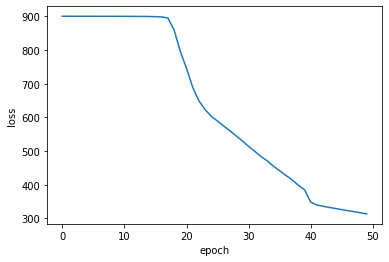

In [12]:
plt.plot(loss_history)
plt.xlabel("epoch")
plt.ylabel("loss")

### 学習の結果を視覚化する

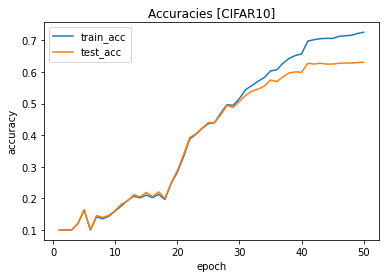

In [13]:
plt.plot(range(1, epoch + 1), train_acc, label='train_acc')
plt.plot(range(1, epoch + 1), test_acc, label='test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()